# Install libraries to test the data for a quick overview after generation

In [1]:
!pip install scanpy loompy umap-learn scrublet loompy > _

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scrublet as scr
import loompy
import os

/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:1

# Random data generation

In [3]:
import pandas as pd
import random
import numpy as np


### Lists of genes to use

In [4]:
# Sex-linked and cell-type marker genes
ylinked=['SRY', 'TSPY', 'USP9Y', 'UTY', 'ZFY']
fem=['XIST','FOXL2','WNT4','PGR','ESR1']
neuron=['MAP2', 'RBFOX3', 'MEG3']
inh=['GAD1', 'FXYD6', 'LHX6', 'CUX2']
exc=['SLC17A7', 'RORB', 'THEMIS']
oligo=['MAG', 'MOG', 'ST18', 'CTNNA3']
opc=['PDGFRA', 'VCAN', 'PTPRZ1', 'LRRC4C']
astro=['SLC1A3', 'AQP4', 'ADGRV1', 'GLIS3']
mglia=['FYB1','CSF1R', 'CTSS', 'C1QA']

## Adding only relevant genes made it look quite unrealistic, add some background/filler genes
background=["BRCA1",    "TP53",    "EGFR",    "MYC",    "TNF",    "INS",
            "APOE",    "HBB",    "CFTR",    "PTEN",    "VEGFA",    "MTHFR",
            "APP",    "AKT1",    "MAPT",    "LPL",    "CYP2D6",    "FGFR2",    "IL6"]
background2=["ATM",    "BRCA2",    "CDKN2A",    "KRAS",    "PTPN11",    "RET",
             "SMAD4",    "TERT",    "TP63",    "WT1",    "FOXP2",    "GATA3",
             "HOXD13",    "KCNQ1",    "LMNA",    "NOD2",    "PAX6",    "RXRA",
             "SFTPB",    "ZBTB16"]
additional_genes = [    "ALDH2",    "BRAF",    "CCND1",    "CYP2C19",
                    "DNMT3A",    "EGF",    "FMR1",    "GHR",    "HLA-B",
                        "IFNG",    "JAK2",    "KIT",    "LRRK2",    "MET",
                        "NFKB1",    "OCA2",    "PDGFRB",    "RARA",    "SHH",
                        "SLC6A4",    "TGFB1",    "TYR",    "UCHL1",    "VDR",
                        "WNT5A",    "ABCA4",    "ATP7B",    "BMPR2",    "CASR",
                        "CYBB",    "EDN1",    "FLG",    "GNAS",    "HNF1A",
                        "IGF1",    "KCNQ1OT1",    "LMNB1",    "MMP9",
                        "NDUFS4",    "PAX3",    "RHO",    "SOD1",    "TBX1",
                        "USH2A",    "VHL",    "XDH",    "YARS",    "ZIC2",
                        "ABCB1",    "ACVR1",    "BTK"]

genes=pd.DataFrame(columns=list(set(ylinked+fem+neuron+inh+exc+oligo+opc+astro+mglia+background+background2+additional_genes)))

# Initially assign a uniform probability to all the genes
genes.loc['prob']=1

# A dictionary so we can generate cells calling their type
cell_types_dict={'neuron+inh':neuron+inh, 'neuron+exc':neuron+exc,'oligo':oligo,'opc':opc,'astro':astro,'mglia':mglia}

## Functions to generate random cells, subjects and cohort

In [5]:
# Return n choices from an array of options with a given set of probabilities
def make_choices(options, probabilities, n):
    return np.random.choice(options, n, p=probabilities)

In [6]:
# Generate counts for a cell specifying the range of counts, sex and genes
# to bias the generation by cell types
def gen_cell(genes, barcode, min_counts, max_counts, sex, cell_type_genes):

    # Determine total counts
    n_counts=random.randint(min_counts, max_counts)

    ## Proability of each gene
    options = genes.columns.values.astype(str)
    # Initial probability is uniform
    prob=genes.copy()
    #probabilities=(genes.loc['prob']/(genes.loc['prob'].sum())).values

    #Add probability bias by sex
    if sex=='F':
        prob[ylinked]=0.01
        prob[fem]+=5
    elif sex=='M':
        prob[ylinked]+=5
        prob[fem]=0.01

    # Add bias by cell type
    prob[cell_type_genes]+=20

    # Normalize probabilities
    prob.loc['prob']=(prob.loc['prob']/(prob.loc['prob'].sum()))

    # Generate "reads"
    choices = pd.Series(make_choices(options, prob.loc['prob'], n_counts))

    # Make a dataframe with counts per gene
    new_cell=pd.DataFrame(choices.value_counts(), columns=[barcode])

    # Use the reference to make a dataframe that includes also undetected genes
    mat=genes.copy() # Make a copy
    mat=mat.transpose() # Transpose so that "prob" is a column
    mat=mat.merge(new_cell,left_index=True, right_index=True, how='outer') # Merge with the new cell
    mat=mat[[barcode]].transpose() # Keep only the new cell (pick column by barcode)

    return mat

In [10]:
# Generate N cells for a subject with a given probability to generate
# "bad quality" cells

def gen_sample(genes,n_cells, sex, ID, prob_low_QC, cell_types_dictionary):

  # Empty count matrix
  mat=genes.copy()

  # Generate n cells
  for i in range(n_cells):
    # Decide whether good or bad quality cell
    QC=np.random.choice(['low','high'], 1, p=[prob_low_QC, 1-prob_low_QC])[0]
    # Define the range of counts for "good"/"bad" cells
    if QC=='low':
      min_counts=5
      max_counts=50
    elif QC=='high':
      min_counts=100
      max_counts=600

    # Assign random cell type
    cell_type=np.random.choice(list(cell_types_dict.keys()), 1, p=[int(x)/len(cell_types_dict) for x in [1]*len(cell_types_dict)])[0]
    # Get corresponding genes
    cell_type_genes=cell_types_dict[cell_type]

    # Generate cell and append to matrix
    cell=gen_cell(genes, f'{ID}_{i}', min_counts, max_counts, sex, cell_type_genes).loc[:,mat.columns]
    mat=pd.concat([mat,cell])

  # the first row is all of 1s, remove it
  mat=mat.iloc[1:,:]

  # Generate obs dataframe
  obs=pd.DataFrame(data=mat.index.values, index=mat.index, columns=['barcode'])
  obs['Sample_name']=ID

  return mat,obs

In [11]:
# Generate N subjects, randomly assign sex. Provide a dictionary of cell types
# and associated genes to randomly assign the cell type of each cell
def gen_cohort(genes, n_subjects, cell_types_dictionary):

  mtx=genes.copy()
  mdata=pd.DataFrame()

  for i in range(n_subjects):
    # Randomly define subject features
    sex=np.random.choice(['F','M'], 1, p=[0.5,0.5])[0]
    cond=np.random.choice(['C','D'], 1, p=[0.5,0.5])[0]
    # Compose subject "name"
    ID=f'{cond}{i+1}'
    # Chance of having cells with low counts/"bad" QC
    prob_low_QC=random.uniform(0.05, 0.15)
    n_cells=random.randint(100, 1000)

    print(f'Generating subject no. {i} with {n_cells} cells, sex={sex}')
    # Generate subject
    mat,obs=gen_sample(genes,n_cells, sex, ID, prob_low_QC, cell_types_dict)
    mtx=pd.concat([mtx,mat])
    mdata=pd.concat([mdata,obs])

  mtx=mtx.iloc[1:,:]
  mdata['Condition']=[i[0] for i in mdata['Sample_name']]
  return mtx, mdata



## Actually making some synthetic data

In [12]:
mtx, mdata= gen_cohort(genes, 10, cell_types_dict)

Generating subject no. 0 with 874 cells, sex=M
Generating subject no. 1 with 554 cells, sex=F
Generating subject no. 2 with 904 cells, sex=F
Generating subject no. 3 with 822 cells, sex=F
Generating subject no. 4 with 721 cells, sex=M
Generating subject no. 5 with 320 cells, sex=M
Generating subject no. 6 with 874 cells, sex=F
Generating subject no. 7 with 743 cells, sex=M
Generating subject no. 8 with 301 cells, sex=M
Generating subject no. 9 with 404 cells, sex=M


# Test the data

In [13]:
adata=sc.AnnData(X=mtx.fillna(0),obs=mdata)

In [14]:
adata

AnnData object with n_obs × n_vars = 6517 × 126
    obs: 'barcode', 'Sample_name', 'Condition'

In [15]:
adata.var_names=mtx.columns

In [16]:
adata.var['var_names']=adata.var_names

In [17]:
#adata.write_h5ad('Toy_data.h5ad')

In [18]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = adata.var_names.str.startswith('mt-')
adata.obs['mt_frac'] = np.squeeze(np.asarray(adata.X[:, mt_gene_mask].sum(1)))/adata.obs['n_counts']

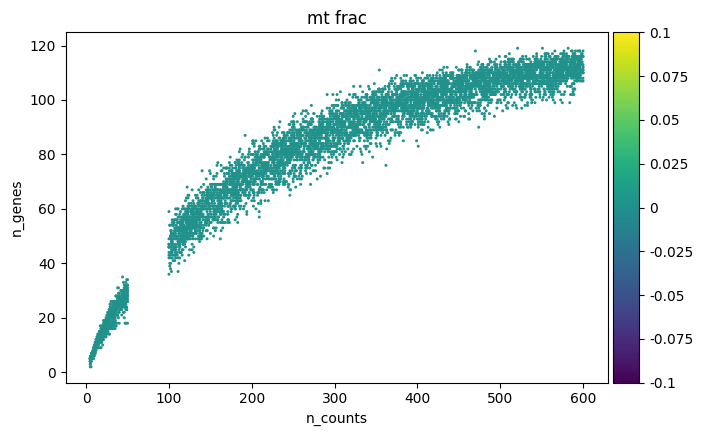

In [19]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')


In [20]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 100) #Playing conservative with this one
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 50000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 50) # Would go for 1000 but might cut out too many cells
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_genes = 7000) # Would go for 1000 but might cut out too many cells
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 6517
Number of cells after min count filter: 5878
Number of cells after max count filter: 5878
Number of cells after gene filter: 5752
Number of cells after gene filter: 5752


In [21]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=25)

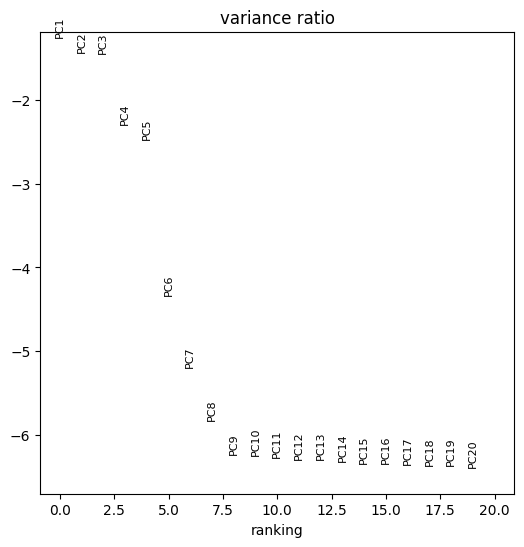

In [22]:
# Calculate the visualizations
plt.rcParams['figure.figsize']=(6,6) #rescale figures

n_pcs=20
sc.pp.pca(adata, n_comps=n_pcs, use_highly_variable=True, svd_solver='arpack',random_state=42)
sc.pl.pca_variance_ratio(adata,n_pcs, log=True)


In [23]:
sc.pp.neighbors(adata,n_pcs=8,random_state=42, metric='cosine')
sc.tl.umap(adata,random_state=42)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


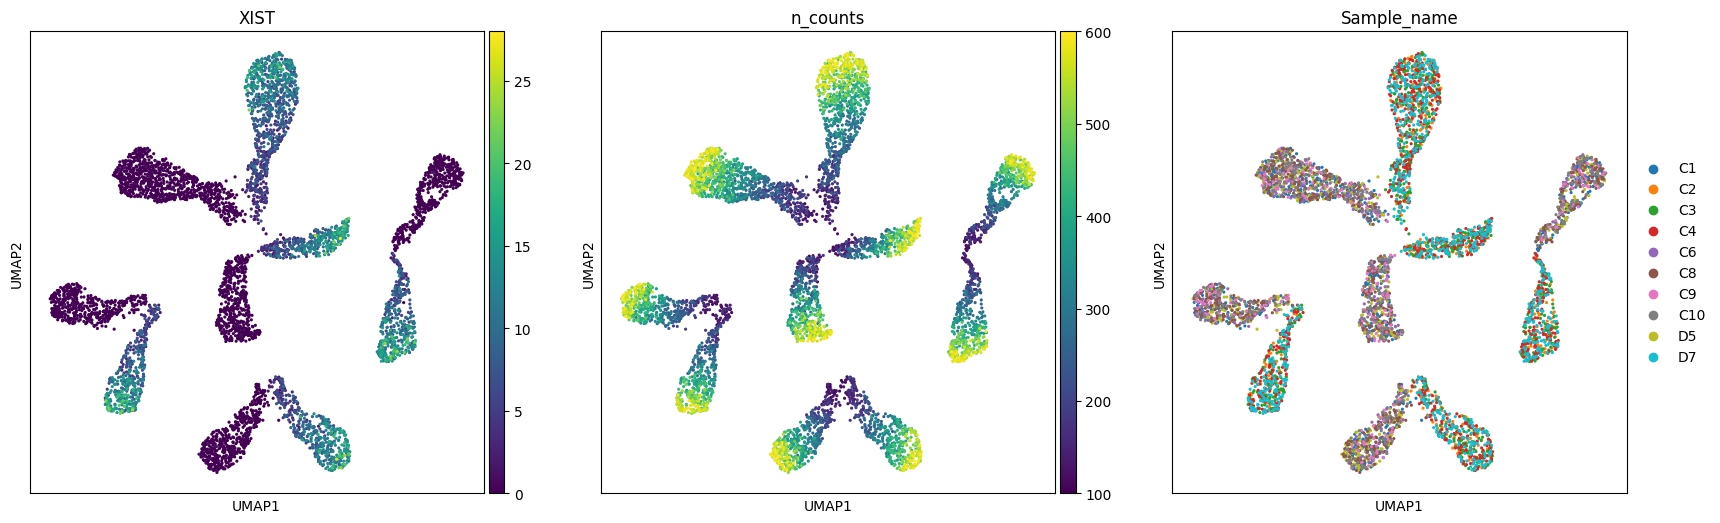

In [24]:
#sc.pl.pca_scatter(adata, color='XIST')
sc.pl.umap(adata, color=['XIST','n_counts','Sample_name'])

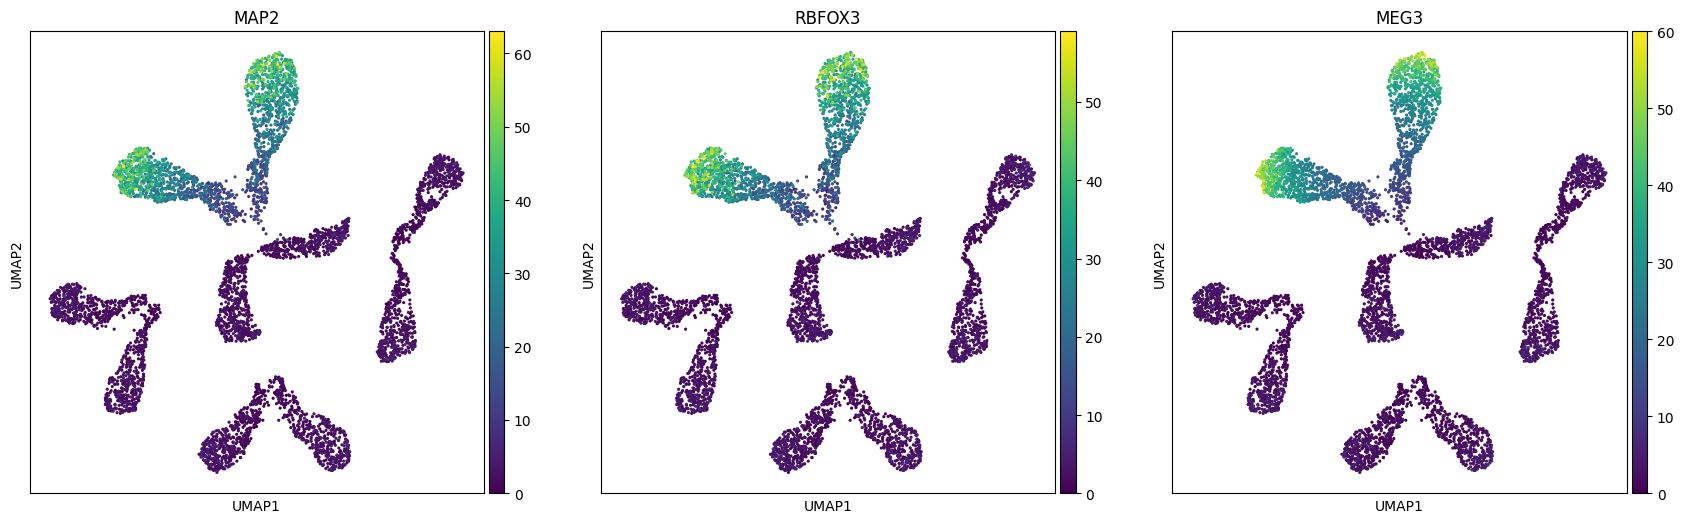

In [25]:
sc.pl.umap(adata, color=neuron)

In [26]:
adata.obs

,barcode,Sample_name,Condition,n_counts,n_genes,mt_frac
C1_0,C1_0,C1,C,271.0,85,0.0
C1_2,C1_2,C1,C,579.0,112,0.0
C1_3,C1_3,C1,C,483.0,108,0.0
C1_4,C1_4,C1,C,274.0,84,0.0
C1_5,C1_5,C1,C,331.0,91,0.0
...,...,...,...,...,...,...
C10_399,C10_399,C10,C,557.0,104,0.0
C10_400,C10_400,C10,C,217.0,83,0.0
C10_401,C10_401,C10,C,450.0,111,0.0
C10_402,C10_402,C10,C,443.0,108,0.0


# Store the data if it looks fine

In [ ]:
#mtx.to_csv('mtx.csv')

In [ ]:
#mdata.to_csv('mdata.csv')